In [0]:
!unzip skindata.zip

In [0]:
!unzip new.zip

In [0]:
rm -r skindata.zip

In [0]:
!ls

new  new.zip  sample_data  skindata


In [0]:
import keras
import numpy as np
from keras.applications import resnet50

resnet_model = resnet50.ResNet50(weights='imagenet') 

In [0]:
resnet_model.summary()

In [0]:
import numpy as np 
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import cv2
import os

In [0]:

IMAGE_WIDTH=188
IMAGE_HEIGHT=188
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

In [0]:
filenames = os.listdir("skindata/yes")
categories = []
fl = []
for filename in filenames:
        categories.append(1)
        fl.append(filename)

filenames = os.listdir("skindata/not")
for filename in filenames:
        categories.append(0)
        fl.append(filename)

df = pd.DataFrame({
    'filename': fl,
    'category': categories
})

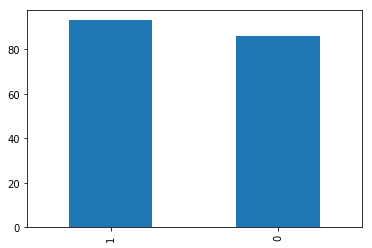

In [0]:
df['category'].value_counts().plot.bar()

In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

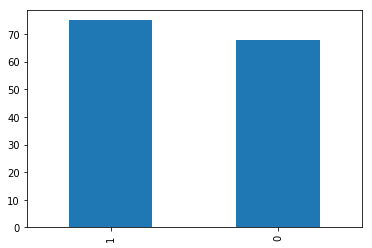

In [0]:
train_df['category'].value_counts().plot.bar()

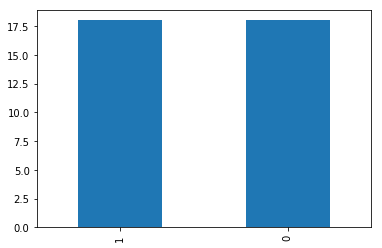

In [0]:
validate_df['category'].value_counts().plot.bar()

In [0]:
from sklearn.utils import shuffle
validate_df = shuffle(validate_df)
train_df = shuffle(train_df)

In [0]:
batch_size = 16

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df.astype(str), 
    "new", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 143 images belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df.astype(str), 
    "new", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 36 images belonging to 2 classes.


In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model



def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

  
  
class_list = ["melanoma","notmelanoma"]
FC_LAYERS = [1024, 1024]
dropout = 0.25



finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [0]:
from keras.optimizers import SGD, Adam

NUM_EPOCHS = 10

num_train_images = 143

adam = Adam(lr = 0.00001)
finetune_model.compile(adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

#filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
#checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
#callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator,
                                       epochs=NUM_EPOCHS,
                                       workers=8, 
                                       steps_per_epoch=num_train_images // batch_size,
                                       shuffle=True)





Epoch 1/10
8/8 [==============================] - 42s 5s/step - loss: 0.3587 - acc: 0.8593
Epoch 2/10
8/8 [==============================] - 35s 4s/step - loss: 0.4582 - acc: 0.8202
Epoch 3/10
8/8 [==============================] - 35s 4s/step - loss: 0.4346 - acc: 0.8427
Epoch 4/10
8/8 [==============================] - 35s 4s/step - loss: 0.3671 - acc: 0.8588
Epoch 5/10
8/8 [==============================] - 35s 4s/step - loss: 0.1879 - acc: 0.9135
Epoch 6/10
8/8 [==============================] - 35s 4s/step - loss: 0.2392 - acc: 0.9140
Epoch 7/10
8/8 [==============================] - 35s 4s/step - loss: 0.3106 - acc: 0.9062
Epoch 8/10
8/8 [==============================] - 35s 4s/step - loss: 0.2981 - acc: 0.8896
Epoch 9/10
8/8 [==============================] - 35s 4s/step - loss: 0.2233 - acc: 0.8979
Epoch 10/10
8/8 [==============================] - 35s 4s/step - loss: 0.1454 - acc: 0.9526


KeyError: ignored

In [0]:
total_validate= 36

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 186, 186, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 186, 186, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 93, 93, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 93, 93, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 91, 91, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 91, 91, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)        0         
__________

In [0]:
epochs = 10 
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=num_train_images//batch_size
)

Epoch 1/10
8/8 [==============================] - 34s 4s/step - loss: 0.6164 - acc: 0.7787 - val_loss: 1.0341 - val_acc: 0.6000
Epoch 2/10
8/8 [==============================] - 30s 4s/step - loss: 0.7583 - acc: 0.7070 - val_loss: 0.8142 - val_acc: 0.8500
Epoch 3/10
8/8 [==============================] - 30s 4s/step - loss: 0.7338 - acc: 0.7088 - val_loss: 0.7396 - val_acc: 0.8438
Epoch 4/10
8/8 [==============================] - 30s 4s/step - loss: 0.6228 - acc: 0.7801 - val_loss: 1.1513 - val_acc: 0.7500
Epoch 5/10
8/8 [==============================] - 30s 4s/step - loss: 0.6172 - acc: 0.7714 - val_loss: 0.3452 - val_acc: 0.9000
Epoch 6/10
8/8 [==============================] - 30s 4s/step - loss: 0.5899 - acc: 0.7801 - val_loss: 1.3033 - val_acc: 0.6562
Epoch 7/10
8/8 [==============================] - 30s 4s/step - loss: 0.6320 - acc: 0.7167 - val_loss: 0.5441 - val_acc: 0.8500
Epoch 8/10
8/8 [==============================] - 30s 4s/step - loss: 0.6641 - acc: 0.7475 - val_loss: 1

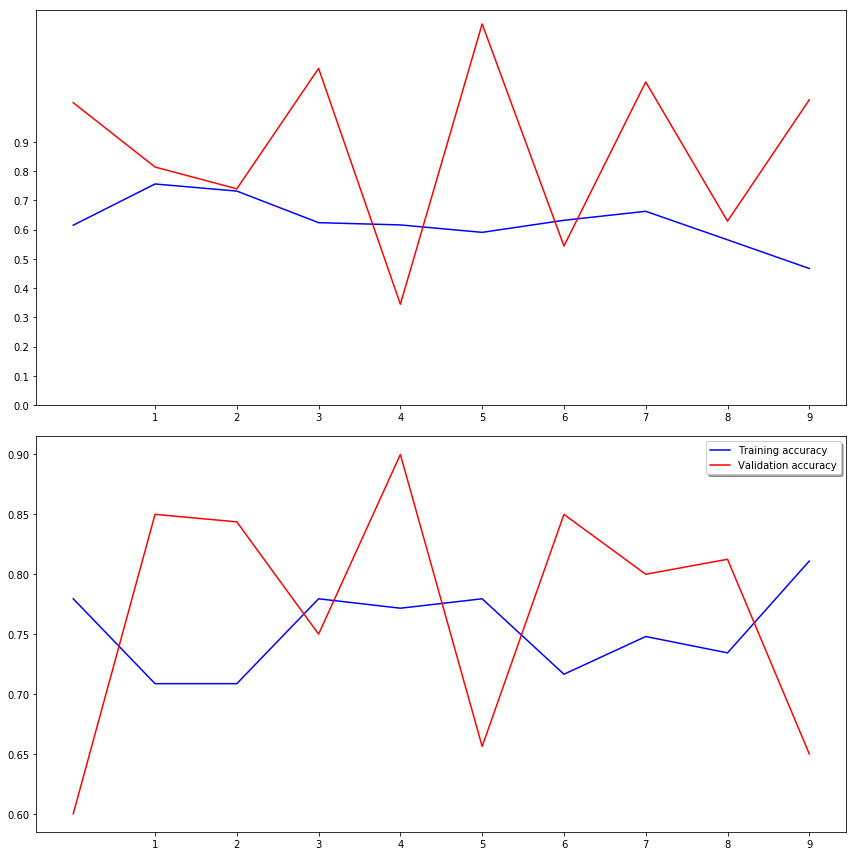

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam


In [0]:

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation



/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 1s 0us/step


In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5
8/8 [==============================] - 35s 4s/step - loss: 1.4136 - acc: 0.6039
Epoch 2/5
8/8 [==============================] - 26s 3s/step - loss: 0.5447 - acc: 0.7645
Epoch 3/5
8/8 [==============================] - 26s 3s/step - loss: 0.3096 - acc: 0.8974
Epoch 4/5
8/8 [==============================] - 26s 3s/step - loss: 0.3583 - acc: 0.8491
Epoch 5/5
8/8 [==============================] - 26s 3s/step - loss: 0.1647 - acc: 0.9526


I have adequatelly cited these notebooks and blog-resources for this notebook----



> https://github.com/aditya9898/transfer-learning/blob/master/transfer-learning.ipynb



> https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e



> https://www.kaggle.com/samrat230599/keras-cnn-dog-or-cat-classification/edit



> https://www.tensorflow.org/alpha/tutorials/images/transfer_learning



> https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50









